# Data Exploration

### Data Set Information:

This data was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios including the destination, current time, weather, passenger, etc., and then ask the person whether he will accept the coupon if he is the driver. For more information about the dataset, please refer to the paper:

##### Wang, Tong, Cynthia Rudin, Finale Doshi-Velez, Yimin Liu, Erica Klampfl, and Perry MacNeille. 'A bayesian framework for learning rule sets for interpretable classification.' The Journal of Machine Learning Research 18, no. 1 (2017): 2357-2393.

[Source](https://archive.ics.uci.edu/ml/datasets/in-vehicle+coupon+recommendation)

### Import necessary packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
df = pd.read_csv('data/in-vehicle-coupon-recommendation.csv')
df.head()

destination  passanger weather  temperature  time  \
0  No Urgent Place      Alone   Sunny           55   2PM   
1  No Urgent Place  Friend(s)   Sunny           80  10AM   
2  No Urgent Place  Friend(s)   Sunny           80  10AM   
3  No Urgent Place  Friend(s)   Sunny           80   2PM   
4  No Urgent Place  Friend(s)   Sunny           80   2PM   

                  coupon expiration  gender age      maritalStatus  ...  \
0        Restaurant(<20)         1d  Female  21  Unmarried partner  ...   
1           Coffee House         2h  Female  21  Unmarried partner  ...   
2  Carry out & Take away         2h  Female  21  Unmarried partner  ...   
3           Coffee House         2h  Female  21  Unmarried partner  ...   
4           Coffee House         1d  Female  21  Unmarried partner  ...   

   CoffeeHouse CarryAway RestaurantLessThan20 Restaurant20To50  \
0        never       NaN                  4~8              1~3   
1        never       NaN                  4~8              1~3   
2        never       NaN                  4~8              1~3   
3        never       NaN                  4~8              1~3   
4        never       NaN                  4~8              1~3   

  toCoupon_GEQ5min toCoupon_GEQ15min toCoupon_GEQ25min direction_same  \
0                1                 0                 0              0   
1                1                 0                 0              0   
2                1                 1                 0              0   
3                1                 1                 0              0   
4                1                 1                 0              0   

  direction_opp  Y  
0             1  1  
1             1  0  
2             1  1  
3             1  0  
4             1  0  

[5 rows x 26 columns]

In [3]:
df.shape

(12684, 26)

### Clean the datasetup
Looking at the [data description](data_description.txt), we will convert several columns to more analysis friends form. Since many columns have categorical data, we will use label encoder.

In [4]:
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head()

destination  passanger weather  time                 coupon expiration  \
0  No Urgent Place      Alone   Sunny   2PM        Restaurant(<20)         1d   
1  No Urgent Place  Friend(s)   Sunny  10AM           Coffee House         2h   
2  No Urgent Place  Friend(s)   Sunny  10AM  Carry out & Take away         2h   
3  No Urgent Place  Friend(s)   Sunny   2PM           Coffee House         2h   
4  No Urgent Place  Friend(s)   Sunny   2PM           Coffee House         1d   

   gender age      maritalStatus                 education  occupation  \
0  Female  21  Unmarried partner  Some college - no degree  Unemployed   
1  Female  21  Unmarried partner  Some college - no degree  Unemployed   
2  Female  21  Unmarried partner  Some college - no degree  Unemployed   
3  Female  21  Unmarried partner  Some college - no degree  Unemployed   
4  Female  21  Unmarried partner  Some college - no degree  Unemployed   

            income  car    Bar CoffeeHouse CarryAway RestaurantLessThan20  \
0  $37500 - $49999  NaN  never       never       NaN                  4~8   
1  $37500 - $49999  NaN  never       never       NaN                  4~8   
2  $37500 - $49999  NaN  never       never       NaN                  4~8   
3  $37500 - $49999  NaN  never       never       NaN                  4~8   
4  $37500 - $49999  NaN  never       never       NaN                  4~8   

  Restaurant20To50  
0              1~3  
1              1~3  
2              1~3  
3              1~3  
4              1~3

In [5]:
obj_df.isna().sum()

destination                 0
passanger                   0
weather                     0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
dtype: int64

In [6]:
# Of 12684 records, column 'car' contains NaN for 12576 records, lets drop it.
obj_df.drop('car',axis=1,inplace=True)

In [7]:
# For each column which has NaN counts greater than 0, check what is the most common values in the column
# for simplicity sake, also a little meaningful to replace the NaN with the most common values.
obj_df["Restaurant20To50"].value_counts()

less1    6077
1~3      3290
never    2136
4~8       728
gt8       264
Name: Restaurant20To50, dtype: int64

In [8]:
obj_df = obj_df.fillna({"Bar": "never",
                        "CoffeeHouse":"less1",
                        "CarryAway":"1~3",
                        "RestaurantLessThan20":"1~3",
                        "Restaurant20To50":"less1"
                       })

In [9]:
# Verify no NaN values are present in the dataframe
obj_df.isna().sum()

destination             0
passanger               0
weather                 0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
dtype: int64

In [10]:
# Let's perform on-hot Encoding using the pandas get_dummies method.
obj_encoded=pd.get_dummies(obj_df)

In [11]:
# Removed from original dataframe, those columns which are already encoded
df_without_enc = df.drop(df.select_dtypes(include=['object']).columns,axis=1)

# And join the encoded dataframe to the df_without_enc
df_encoded = df_without_enc.join(obj_encoded)

target = df_encoded[['Y']]
df_encoded = df_encoded.drop('Y', axis=1)

df_encoded.head()

temperature  has_children  toCoupon_GEQ5min  toCoupon_GEQ15min  \
0           55             1                 1                  0   
1           80             1                 1                  0   
2           80             1                 1                  1   
3           80             1                 1                  1   
4           80             1                 1                  1   

   toCoupon_GEQ25min  direction_same  direction_opp  destination_Home  \
0                  0               0              1                 0   
1                  0               0              1                 0   
2                  0               0              1                 0   
3                  0               0              1                 0   
4                  0               0              1                 0   

   destination_No Urgent Place  destination_Work  ...  \
0                            1                 0  ...   
1                            1                 0  ...   
2                            1                 0  ...   
3                            1                 0  ...   
4                            1                 0  ...   

   RestaurantLessThan20_1~3  RestaurantLessThan20_4~8  \
0                         0                         1   
1                         0                         1   
2                         0                         1   
3                         0                         1   
4                         0                         1   

   RestaurantLessThan20_gt8  RestaurantLessThan20_less1  \
0                         0                           0   
1                         0                           0   
2                         0                           0   
3                         0                           0   
4                         0                           0   

   RestaurantLessThan20_never  Restaurant20To50_1~3  Restaurant20To50_4~8  \
0                           0                     1                     0   
1                           0                     1                     0   
2                           0                     1                     0   
3                           0                     1                     0   
4                           0                     1                     0   

   Restaurant20To50_gt8  Restaurant20To50_less1  Restaurant20To50_never  
0                     0                       0                       0  
1                     0                       0                       0  
2                     0                       0                       0  
3                     0                       0                       0  
4                     0                       0                       0  

[5 rows x 109 columns]

In [12]:
# Loop Function to identify number of principal components that explain at least 85% of the variance
for comp in range(3, df_encoded.shape[1]):
    pca = PCA(n_components= comp, random_state=42)
    pca.fit(scale(df_encoded))
    comp_check = pca.explained_variance_ratio_
    final_comp = comp
    if comp_check.sum() > 0.86:
        break
        
Final_PCA = PCA(n_components= final_comp,random_state=42)
Final_PCA.fit(df_encoded)

num_comps = comp_check.shape[0]
print("Using {} components, we can explain {}% of the variability in the original data.".format(final_comp,round(comp_check.sum()*100,2)))

Using 63 components, we can explain 86.33% of the variability in the original data.


In [13]:
pca = PCA(n_components=final_comp, random_state=42)
pca.fit(scale(df_encoded))

PCA(n_components=63, random_state=42)

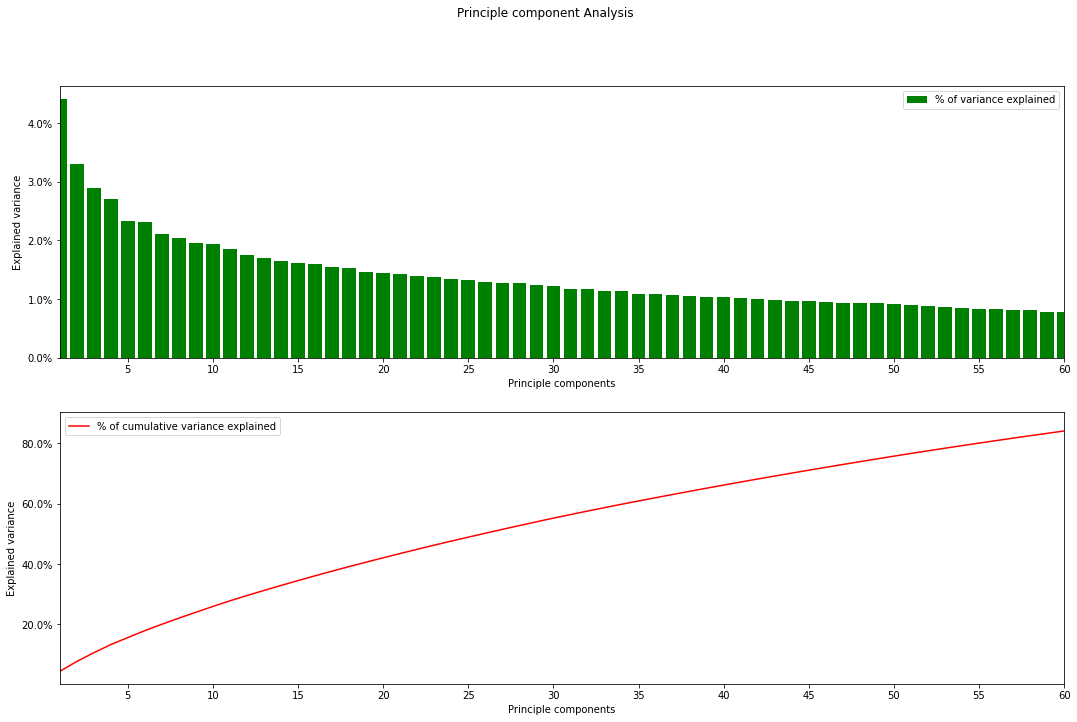

In [14]:
bar_range = pca.n_components_+1
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.rcParams['figure.figsize'] = [18, 11]

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

fig.suptitle('Principle component Analysis')


ax1.bar(list(range(1, bar_range)),pca.explained_variance_ratio_,color='g',label="% of variance explained")
ax1.legend(loc='upper right')


ax2.plot(list(range(1, bar_range)), np.cumsum(pca.explained_variance_ratio_), color='r',label="% of cumulative variance explained")
ax2.legend(loc='upper left')

for ax in [ax1,ax2]:
    ax.set_xlim([1,60])
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=1))
    ax.set_xlabel('Principle components')
    ax.set_ylabel('Explained variance')
    plt.setp(ax, xticks=[s for s in range(1, bar_range) if s%5==0])
    

plt.show()


In [15]:
cluster_df=Final_PCA.transform(df_encoded)
pca_df = pd.DataFrame(cluster_df,columns=[f'PC{i}' for i in range(1,final_comp+1)])

# Logistic Regression
## Split the dataset

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(pca_df,target['Y'],train_size=0.9, test_size=0.1, random_state=42)

In [17]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=1.5,random_state=42)

In [18]:
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [19]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, Y_test)))

Accuracy of logistic regression classifier on test set: 0.68


In [20]:
confusion_matrix = confusion_matrix(Y_test, Y_pred)
print(confusion_matrix)

[[316 243]
 [162 548]]


### we have 316 + 548 correct predictions and 162+243 incorrect predictions

#### Compute precision, recall, F-measure and support
To quote from [Scikit Learn](https://scikit-learn.org/stable/index.html):

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important.

The support is the number of occurrences of each class in y_test.

In [21]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.66      0.57      0.61       559
           1       0.69      0.77      0.73       710

    accuracy                           0.68      1269
   macro avg       0.68      0.67      0.67      1269
weighted avg       0.68      0.68      0.68      1269



### Interpretation
From the test set, 68% of the recommendation were recommendations that people chose for.

In [22]:
logit_roc_auc = roc_auc_score(Y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, model.predict_proba(X_test)[:,1])


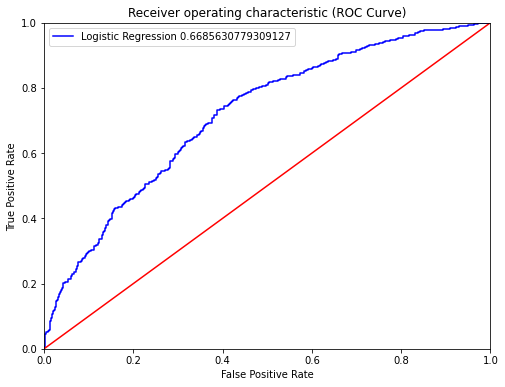

In [23]:
fig = plt.figure(figsize=(8, 6))

plt.title("Receiver operating characteristic (ROC Curve)")
plt.plot(fpr, tpr, color='b',label="Logistic Regression {}".format(logit_roc_auc))
plt.plot([0,1],[0,1],color='r')
plt.xlim([0,1]); plt.xlabel('False Positive Rate')
plt.ylim([0,1]); plt.ylabel('True Positive Rate')
plt.legend(loc="upper left")
plt.show()